In [94]:
import json
import numpy as np
import matplotlib.pyplot as plt
from utils.udp_util import extract_udp_prague_to_dataframe
from utils.plotter import  plot_matplotlib_graph, plot_plotly_graph, plot_cdf_matplotlib, plot_cdf_plotly, plot_boxplot_seaborn
from utils.util import extract_iperf3_data_df, find_files_by_folder
from datetime import datetime
import pandas as pd

In [95]:
import os



# Usage example
root_folder = "../data"
file_extensions = [".json"]  # Add whatever extensions you want

files_dict = find_files_by_folder(root_folder, file_extensions)
print(files_dict)


{'udp_net_2025-08-13-14-08-29_best_cake': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_cake\\iperf3_client_cubic_iperf3_d300_best_cake.json', 'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_cake\\iperf3_server_cubic_iperf3_d300_best_cake.json', 'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_cake\\udp_prague_receiver_iperf3_d300_best_cake.json'], 'udp_net_2025-08-13-14-08-29_best_codel': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_codel\\iperf3_client_cubic_iperf3_d300_best_codel.json', 'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_codel\\iperf3_server_cubic

In [96]:
files_dict.keys()

dict_keys(['udp_net_2025-08-13-14-08-29_best_cake', 'udp_net_2025-08-13-14-08-29_best_codel', 'udp_net_2025-08-13-14-08-29_best_dualpi2', 'udp_net_2025-08-13-14-08-29_best_fq_codel', 'udp_net_2025-08-13-14-08-29_best_fq_pie', 'udp_net_2025-08-13-14-08-29_best_pfifo', 'udp_net_2025-08-13-15-05-15_baseline_cake', 'udp_net_2025-08-13-15-05-15_baseline_codel', 'udp_net_2025-08-13-15-05-15_baseline_dualpi2', 'udp_net_2025-08-13-15-05-15_baseline_fq_codel', 'udp_net_2025-08-13-15-05-15_baseline_fq_pie', 'udp_net_2025-08-13-15-05-15_baseline_pfifo'])

In [97]:
from utils.util import create_directory_if_not_exists
import os
graph_directory = os.path.join("./", "Graphs")
create_directory_if_not_exists(graph_directory)

Directory already exists: ./Graphs


In [98]:
from datetime import datetime

def extract_latest_by_type(files_dict):
    tags = ["fq_codel", "codel", "cake", "fq_pie", "pfifo", "dualpi2"]
    best = None
    best_time = None
    baseline = None
    baseline_time = None

    for key in files_dict:
        parts = key.split('_')
        # Expect: udp, net, 2025-08-12-14-23-07, best|baseline, tag
        if len(parts) < 5:
            continue  # unexpected format

        timestamp_str = parts[2]  # 2025-08-12-14-23-07
        type_str = parts[3]       # best or baseline
        aqm_tag = "_".join(parts[4:])  # join in case tag has underscore like fq_codel

        if aqm_tag not in tags:
            continue  # skip if tag not in our list

        try:
            timestamp = datetime.strptime(timestamp_str, "%Y-%m-%d-%H-%M-%S")
        except ValueError:
            continue

        if type_str == 'best' and (best_time is None or timestamp > best_time):
            best_time = timestamp
            best = key
        elif type_str == 'baseline' and (baseline_time is None or timestamp > baseline_time):
            baseline_time = timestamp
            baseline = key

    return {
        'DRL_allocation': files_dict[best] if best else {},
        'Random_allocation': files_dict[baseline] if baseline else {}
    }

# Usage
latest_folders = extract_latest_by_type(files_dict)

In [99]:
from datetime import datetime

def extract_latest_by_type(files_dict):
    tags = ["fq_codel", "codel", "cake", "fq_pie", "pfifo", "dualpi2"]
    results = []

    for tag in tags:
        best = None
        best_time = None
        baseline = None
        baseline_time = None

        for key in files_dict:
            parts = key.split('_')
            if len(parts) < 5:
                continue

            timestamp_str = parts[2]       # 2025-08-12-15-06-24
            type_str = parts[3]            # best or baseline
            aqm_tag = "_".join(parts[4:])  # e.g. fq_codel

            if aqm_tag != tag:
                continue  # only process this tag's files

            try:
                timestamp = datetime.strptime(timestamp_str, "%Y-%m-%d-%H-%M-%S")
            except ValueError:
                continue

            if type_str == 'best' and (best_time is None or timestamp > best_time):
                best_time = timestamp
                best = key
            elif type_str == 'baseline' and (baseline_time is None or timestamp > baseline_time):
                baseline_time = timestamp
                baseline = key

        results.append({
            "tag": tag,
            "DRL_allocation": files_dict[best] if best else {},
            "Random_allocation": files_dict[baseline] if baseline else {}
        })

    return results


In [100]:
from datetime import datetime

def extract_latest_by_type(files_dict):
    tags = ["fq_codel", "codel", "cake", "fq_pie", "pfifo", "dualpi2"]
    results = []

    for tag in tags:
        best = None
        best_time = None
        baseline = None
        baseline_time = None

        for key in files_dict:
            parts = key.split('_')
            if len(parts) < 5:
                continue

            timestamp_str = parts[2]       # 2025-08-12-15-06-24
            type_str = parts[3]            # best or baseline
            aqm_tag = "_".join(parts[4:])  # e.g. fq_codel

            if aqm_tag != tag:
                continue  # only process this tag's files

            try:
                timestamp = datetime.strptime(timestamp_str, "%Y-%m-%d-%H-%M-%S")
            except ValueError:
                continue

            if type_str == 'best' and (best_time is None or timestamp > best_time):
                best_time = timestamp
                best = key
            elif type_str == 'baseline' and (baseline_time is None or timestamp > baseline_time):
                baseline_time = timestamp
                baseline = key

        results.append({
            "tag": tag,
            "DRL_allocation": files_dict[best] if best else {},
            "Random_allocation": files_dict[baseline] if baseline else {}
        })

    return results


In [101]:
latest_folders = extract_latest_by_type(files_dict)

In [102]:
latest_folders

[{'tag': 'fq_codel',
  'DRL_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_fq_codel\\iperf3_client_cubic_iperf3_d300_best_fq_codel.json',
   'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_fq_codel\\iperf3_server_cubic_iperf3_d300_best_fq_codel.json',
   'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_fq_codel\\udp_prague_receiver_iperf3_d300_best_fq_codel.json'],
  'Random_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-15-05-15_baseline_fq_codel\\iperf3_client_cubic_iperf3_d300_baseline_fq_codel.json',
   'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-15-05-15_base

In [103]:
latest_folders

[{'tag': 'fq_codel',
  'DRL_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_fq_codel\\iperf3_client_cubic_iperf3_d300_best_fq_codel.json',
   'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_fq_codel\\iperf3_server_cubic_iperf3_d300_best_fq_codel.json',
   'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_fq_codel\\udp_prague_receiver_iperf3_d300_best_fq_codel.json'],
  'Random_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-15-05-15_baseline_fq_codel\\iperf3_client_cubic_iperf3_d300_baseline_fq_codel.json',
   'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-15-05-15_base

In [104]:
len(latest_folders)

6

In [105]:
latest_folders[0]

{'tag': 'fq_codel',
 'DRL_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_fq_codel\\iperf3_client_cubic_iperf3_d300_best_fq_codel.json',
  'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_fq_codel\\iperf3_server_cubic_iperf3_d300_best_fq_codel.json',
  'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_fq_codel\\udp_prague_receiver_iperf3_d300_best_fq_codel.json'],
 'Random_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-15-05-15_baseline_fq_codel\\iperf3_client_cubic_iperf3_d300_baseline_fq_codel.json',
  'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-15-05-15_baseline_f

In [106]:
tfcubic = extract_iperf3_data_df(latest_folders[0]['DRL_allocation'][0])
utf = extract_udp_prague_to_dataframe(latest_folders[0]['DRL_allocation'][2])

In [107]:
# import pandas as pd

# # Assuming you already have tfcubic loaded
# q1 = tfcubic['SmoothedRTT'].quantile(0.25)
# q3 = tfcubic['SmoothedRTT'].quantile(0.75)
# iqr = q3 - q1

# # Define bounds for non-outliers
# lower_bound = q1 - 1.5 * iqr
# upper_bound = q3 + 1.5 * iqr

# # Filter out outliers
# tfcubic_cleaned = tfcubic[(tfcubic['SmoothedRTT'] >= lower_bound) & (tfcubic['SmoothedRTT'] <= upper_bound)]


In [108]:
# Define a function to remove outliers based on IQR for a given column
def remove_outliers_iqr(df, columns=['SmoothedRTT', 'thrpt']):

    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Filter rows where values are within the bounds
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]   

    return df

In [ ]:
def plot_all_timeseries(paths, tags = "aqm"):

    scenario = str("RTT_UDPPraguevsCubic")
    plot_matplotlib_graph(paths=paths,
                    ycolumn="SmoothedRTT",
                    title=f"{scenario} SmoothedRTT",
                    xlabel="Time (s)",
                    ylabel="SmoothedRTT (ms)",
                    filename=f'{scenario}',
                    graph_directory=graph_directory,
    )

    scenario = str("Thrpt_UDPPraguevsCubic")
    plot_matplotlib_graph(paths=paths,
                    ycolumn="thrpt",
                    title=f"{scenario} Throuhghput",
                    xlabel="Time (s)",
                    ylabel="Throuhghput (mbps)",
                    filename=f'{scenario}',
                    graph_directory=graph_directory,
    )


    scenario = str("PktLoss_UDPPraguevsCubic")
    plot_matplotlib_graph(paths=paths,
                    ycolumn="Lost_Packets",
                    title=f"{scenario} Packet Loss",
                    xlabel="Time (s)",
                    ylabel="Packet Loss",
                    filename=f'{scenario}',
                    graph_directory=graph_directory,
    )


In [ ]:
def plot_all_cdf(paths, tags = "aqm"):

    # Convert paths dict of DataFrames to dict of arrays for CDF plot
    def get_cdf_data(paths, ycolumn):
        cdf_data = {}
        for label, df in paths.items():
            cdf_data[label] = df[ycolumn].dropna().values
        return cdf_data


    scenario = "RTT_UDPPraguevsCubic" + "_{tag}"
    cdf_data = get_cdf_data(paths, "SmoothedRTT")
    plot_cdf_matplotlib(
        data_dict=cdf_data,
        xlabel="SmoothedRTT (ms)",
        ylabel="CDF",
        title=f"{scenario} SmoothedRTT CDF",
        filename=f"{scenario}_SmoothedRTT_CDF",
        folder=graph_directory,
    )

    scenario = "Thrpt_UDPPraguevsCubic" + "_{tag}"
    cdf_data = get_cdf_data(paths, "thrpt")
    plot_cdf_matplotlib(
        data_dict=cdf_data,
        xlabel="Throughput (mbps)",
        ylabel="CDF",
        title=f"{scenario} Throughput CDF",
        filename=f"{scenario}_Thrpt_CDF",
        folder=graph_directory,
    )

    scenario = "PktLoss_UDPPraguevsCubic" + "_{tag}"
    cdf_data = get_cdf_data(paths, "Lost_Packets")
    plot_cdf_matplotlib(
        data_dict=cdf_data,
        xlabel="Packet Loss",
        ylabel="CDF",
        title=f"{scenario} Packet Loss CDF",
        filename=f"{scenario}_PktLoss_CDF",
        folder=graph_directory,
    )


In [ ]:
def plot_all_boxplot(paths, tags = "aqm"):

    def combine_for_boxplot(paths, ycolumn):
        combined_rows = []
        for label, df in paths.items():
            temp_df = df[[ycolumn]].copy()
            temp_df['Scenario'] = label
            combined_rows.append(temp_df)
        combined_df = pd.concat(combined_rows, ignore_index=True)
        return combined_df


    scenario = "RTT_UDPPraguevsCubic"
    boxplot_df = combine_for_boxplot(paths, "SmoothedRTT")
    plot_boxplot_seaborn(
        dataframe=boxplot_df,
        column="SmoothedRTT",
        groupby="Scenario",
        title=f"{scenario} SmoothedRTT Boxplot",
        xlabel="Scenario",
        ylabel="SmoothedRTT (ms)",
        filename=f"{scenario}_SmoothedRTT_Boxplot",
        folder=graph_directory,
    )

    scenario = "Thrpt_UDPPraguevsCubic"
    boxplot_df = combine_for_boxplot(paths, "thrpt")
    plot_boxplot_seaborn(
        dataframe=boxplot_df,
        column="thrpt",
        groupby="Scenario",
        title=f"{scenario} Throughput Boxplot",
        xlabel="Scenario",
        ylabel="Throughput (mbps)",
        filename=f"{scenario}_Thrpt_Boxplot",
        folder=graph_directory,
    )

    scenario = "PktLoss_UDPPraguevsCubic"
    boxplot_df = combine_for_boxplot(paths, "Lost_Packets")
    plot_boxplot_seaborn(
        dataframe=boxplot_df,
        column="Lost_Packets",
        groupby="Scenario",
        title=f"{scenario} Packet Loss Boxplot",
        xlabel="Scenario",
        ylabel="Packet Loss",
        filename=f"{scenario}_PktLoss_Boxplot",
        folder=graph_directory,
    )


*=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=*
AQM:  fq_codel
{'tag': 'fq_codel', 'DRL_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_fq_codel\\iperf3_client_cubic_iperf3_d300_best_fq_codel.json', 'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_fq_codel\\iperf3_server_cubic_iperf3_d300_best_fq_codel.json', 'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_fq_codel\\udp_prague_receiver_iperf3_d300_best_fq_codel.json'], 'Random_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-15-05-15_baseline_fq_codel\\iperf3_client_cubic_iperf3_d300_basel

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


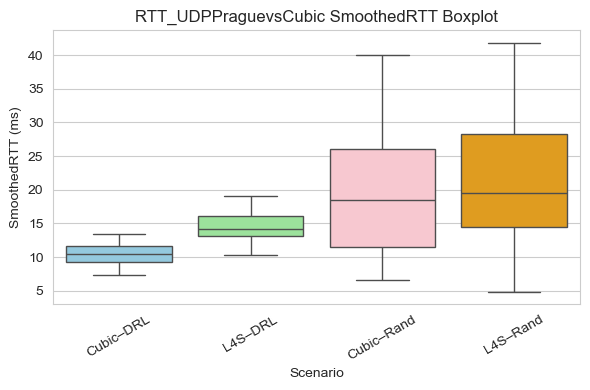

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


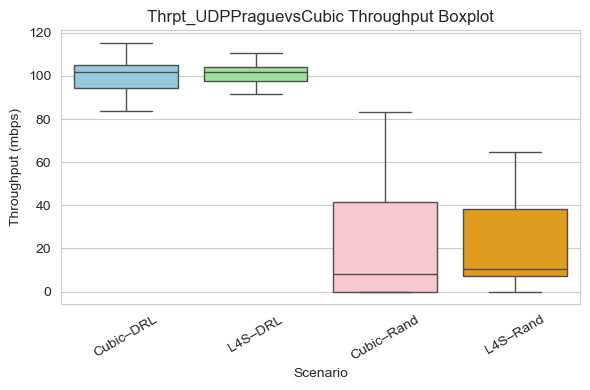

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


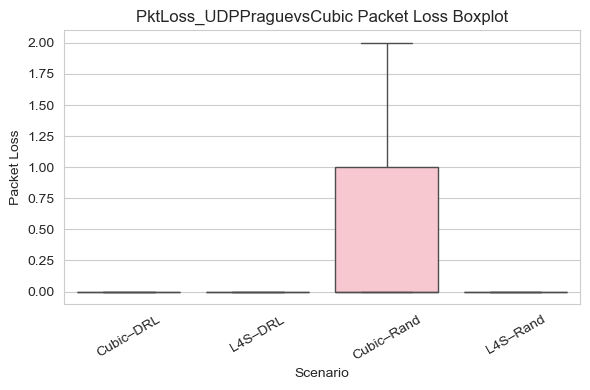

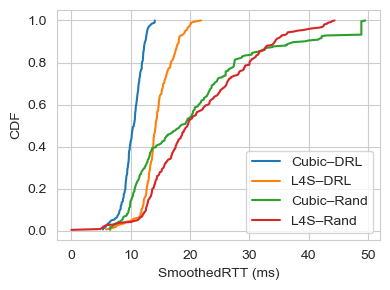

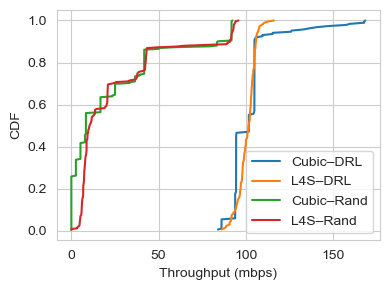

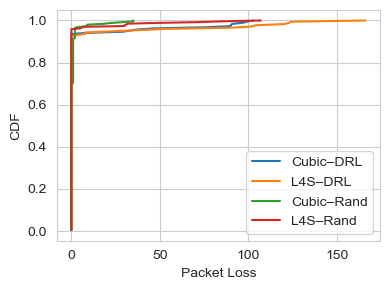

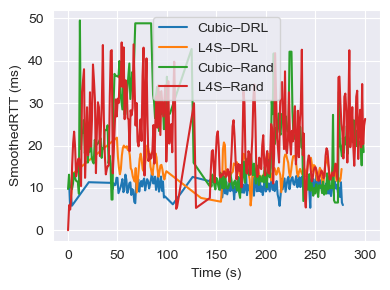

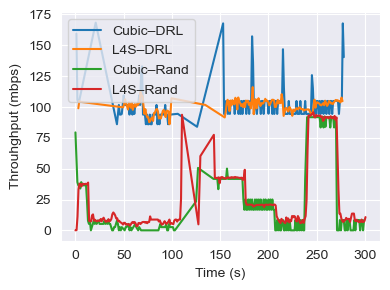

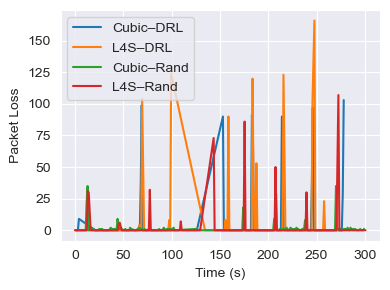

==== SUccess +++
*=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=*
AQM:  codel
{'tag': 'codel', 'DRL_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_codel\\iperf3_client_cubic_iperf3_d300_best_codel.json', 'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_codel\\iperf3_server_cubic_iperf3_d300_best_codel.json', 'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_codel\\udp_prague_receiver_iperf3_d300_best_codel.json'], 'Random_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-15-05-15_baseline_codel\\iperf3_client_cubic_iperf3_d300_baseline_codel.

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


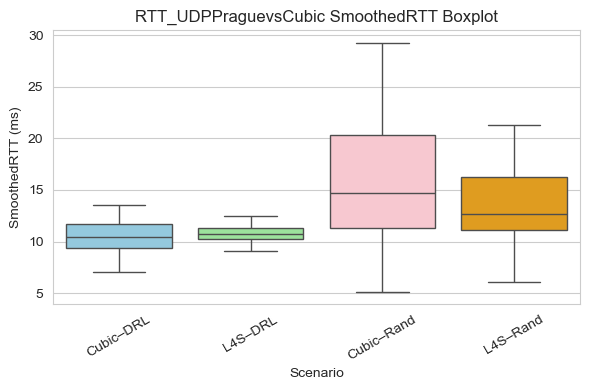

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


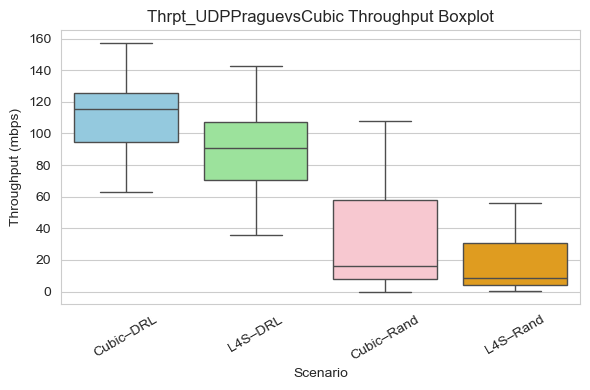

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


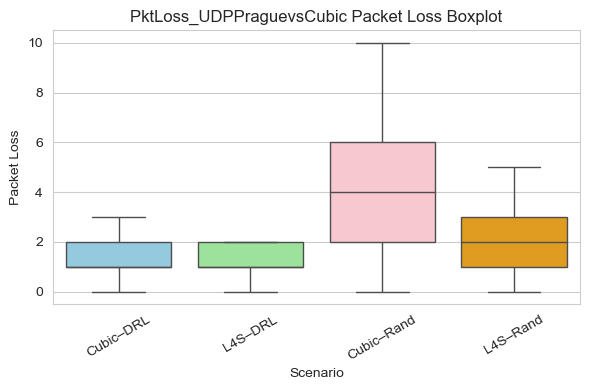

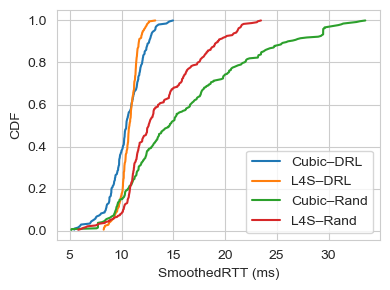

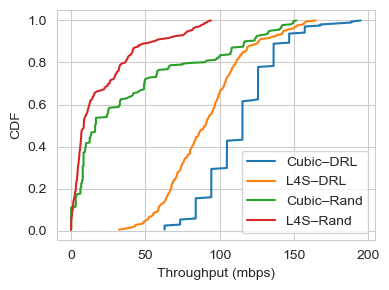

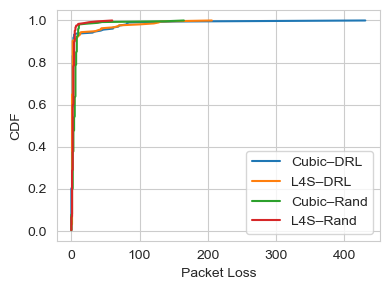

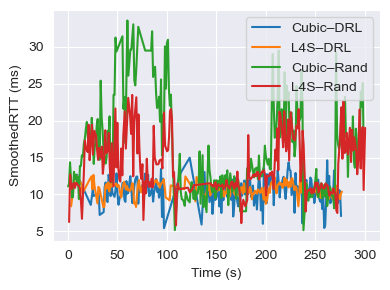

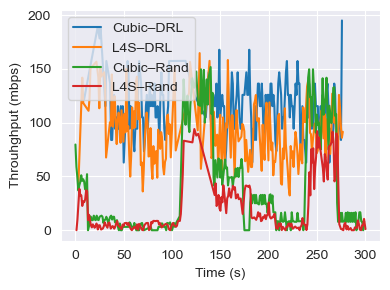

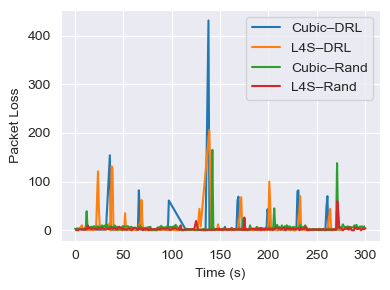

==== SUccess +++
*=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=*
AQM:  cake
{'tag': 'cake', 'DRL_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_cake\\iperf3_client_cubic_iperf3_d300_best_cake.json', 'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_cake\\iperf3_server_cubic_iperf3_d300_best_cake.json', 'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_cake\\udp_prague_receiver_iperf3_d300_best_cake.json'], 'Random_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-15-05-15_baseline_cake\\iperf3_client_cubic_iperf3_d300_baseline_cake.json', 'c:

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


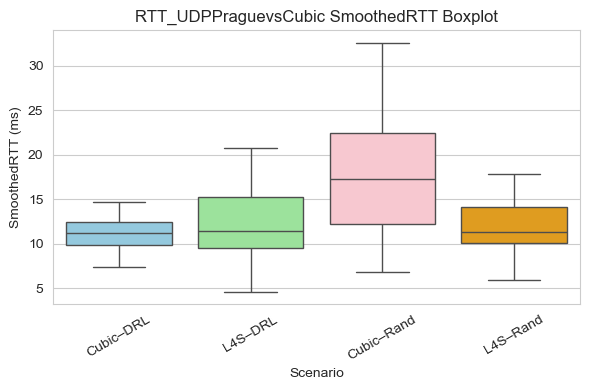

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


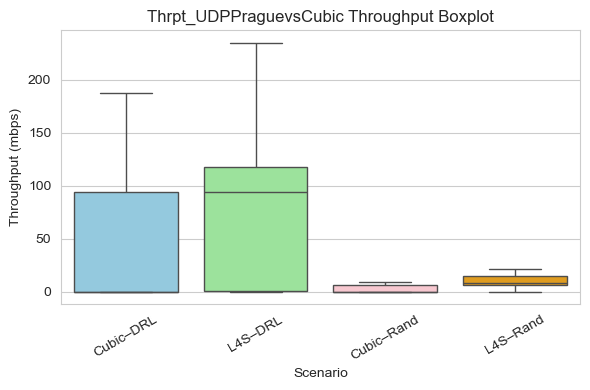

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


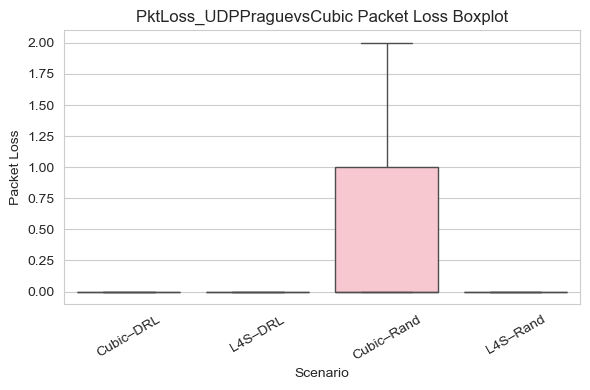

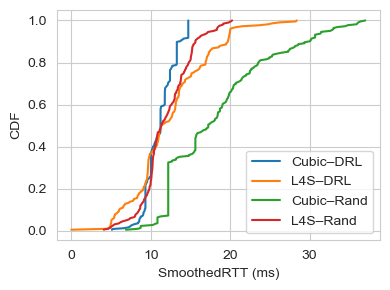

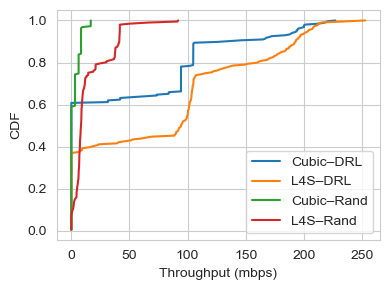

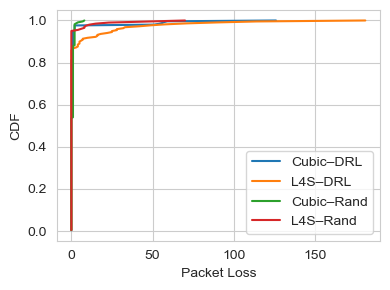

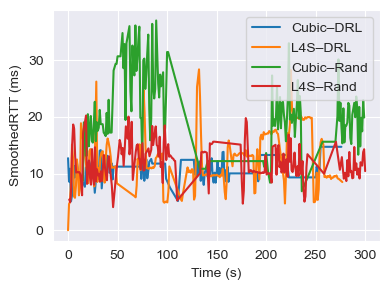

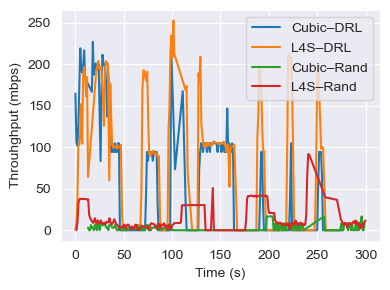

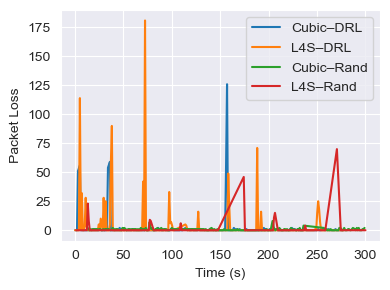

==== SUccess +++
*=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=*
AQM:  fq_pie
{'tag': 'fq_pie', 'DRL_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_fq_pie\\iperf3_client_cubic_iperf3_d300_best_fq_pie.json', 'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_fq_pie\\iperf3_server_cubic_iperf3_d300_best_fq_pie.json', 'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_fq_pie\\udp_prague_receiver_iperf3_d300_best_fq_pie.json'], 'Random_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-15-05-15_baseline_fq_pie\\iperf3_client_cubic_iperf3_d300_baseli

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


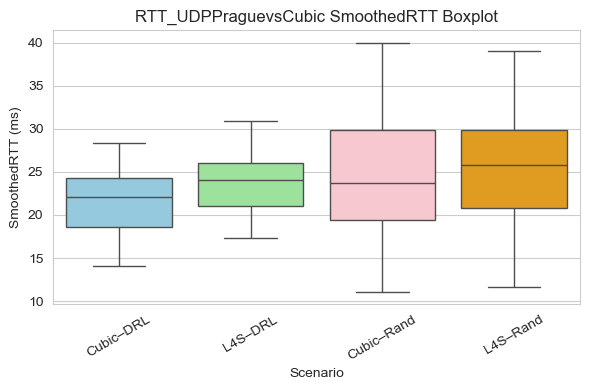

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


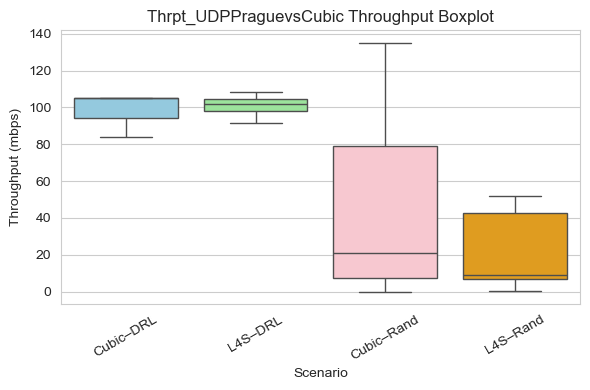

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


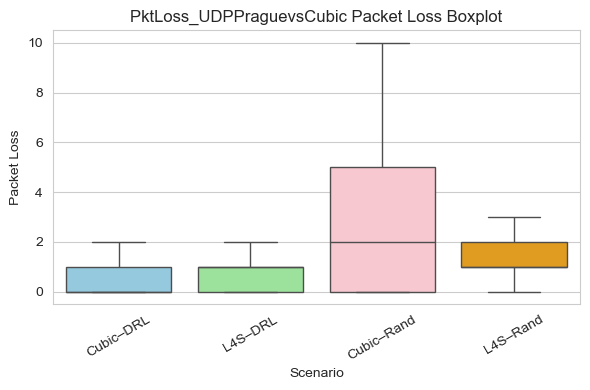

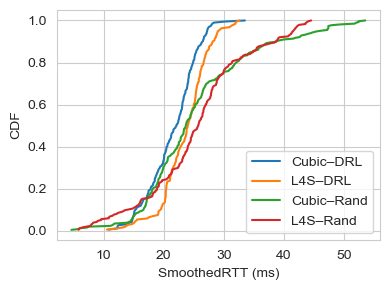

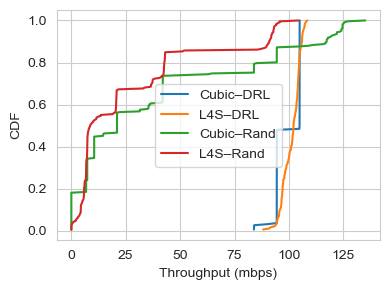

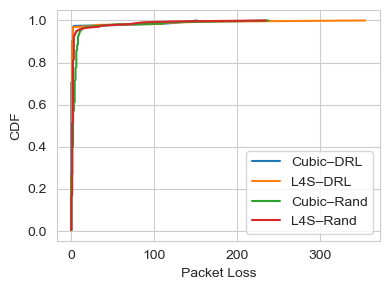

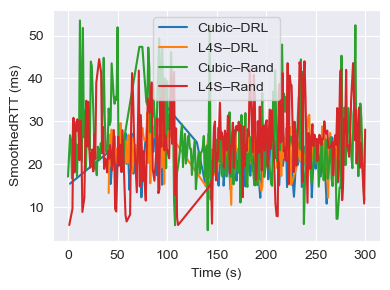

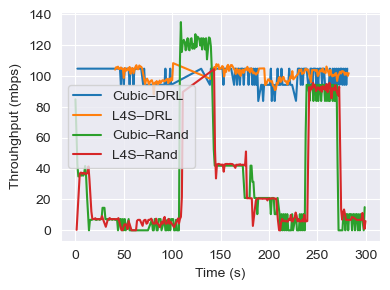

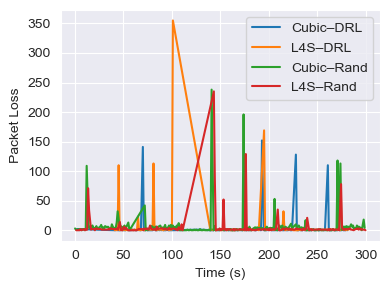

==== SUccess +++
*=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=*
AQM:  pfifo
{'tag': 'pfifo', 'DRL_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_pfifo\\iperf3_client_cubic_iperf3_d300_best_pfifo.json', 'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_pfifo\\iperf3_server_cubic_iperf3_d300_best_pfifo.json', 'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_pfifo\\udp_prague_receiver_iperf3_d300_best_pfifo.json'], 'Random_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-15-05-15_baseline_pfifo\\iperf3_client_cubic_iperf3_d300_baseline_pfifo.

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


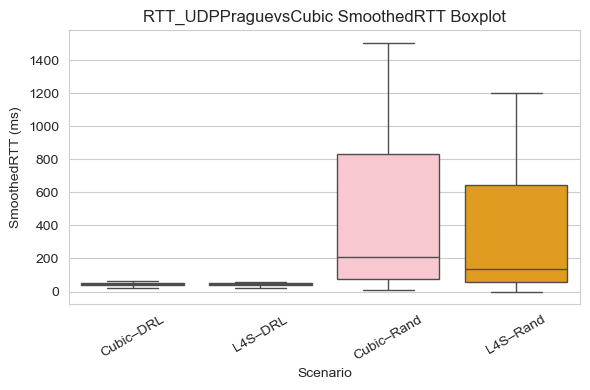

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


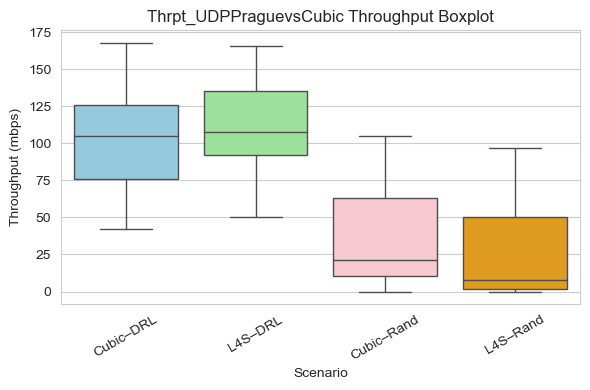

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


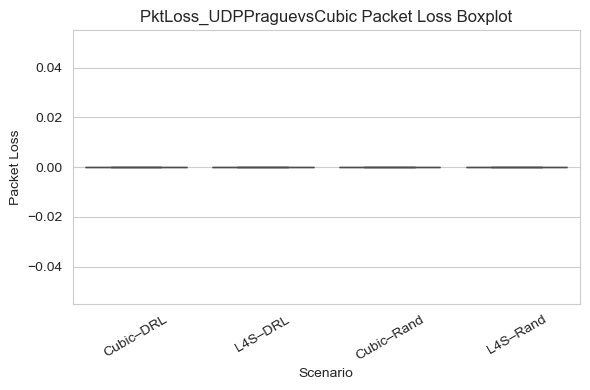

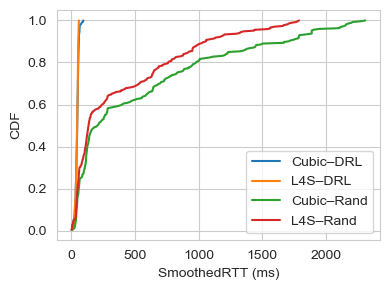

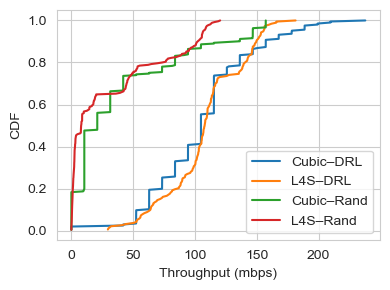

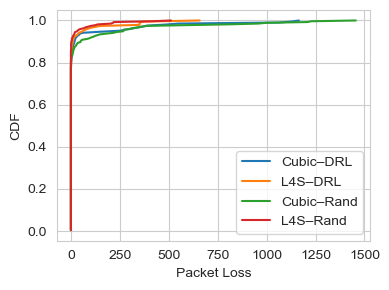

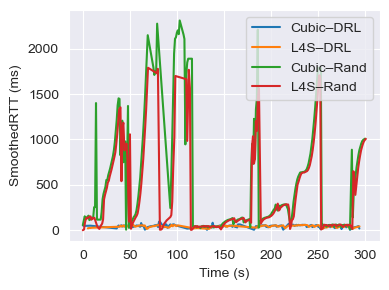

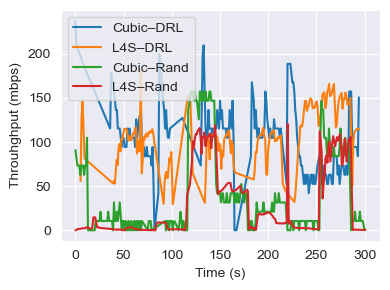

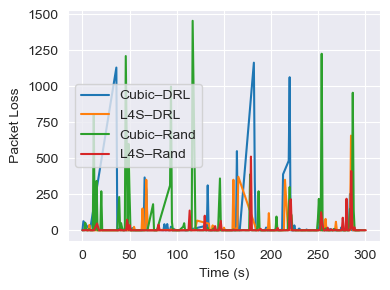

==== SUccess +++
*=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=*
AQM:  dualpi2
{'tag': 'dualpi2', 'DRL_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_dualpi2\\iperf3_client_cubic_iperf3_d300_best_dualpi2.json', 'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_dualpi2\\iperf3_server_cubic_iperf3_d300_best_dualpi2.json', 'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_dualpi2\\udp_prague_receiver_iperf3_d300_best_dualpi2.json'], 'Random_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-15-05-15_baseline_dualpi2\\iperf3_client_cubic_iperf3_d3

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


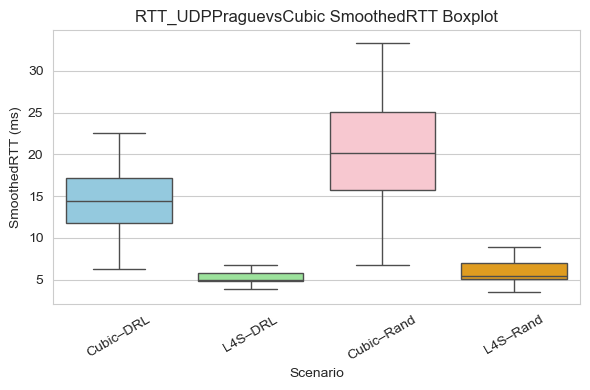

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


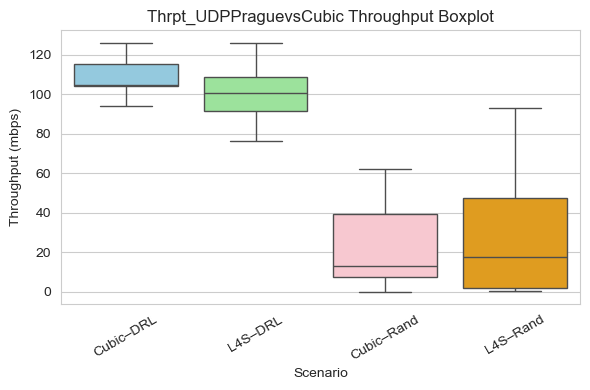

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


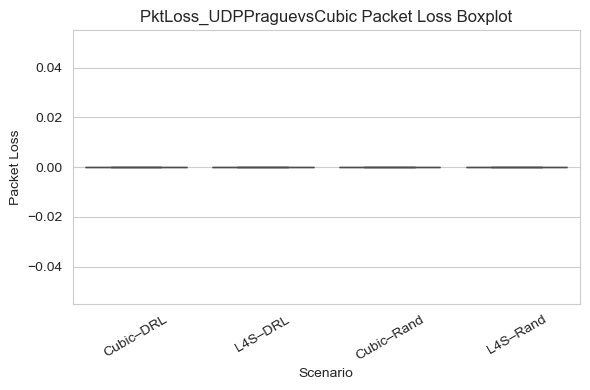

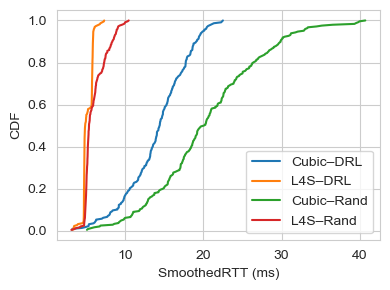

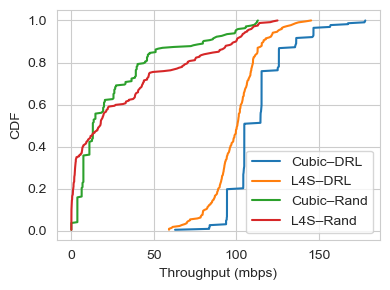

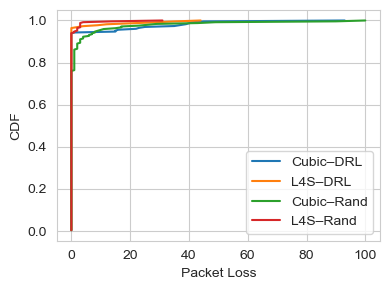

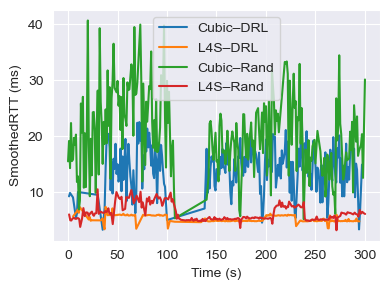

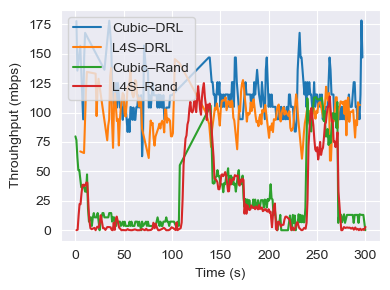

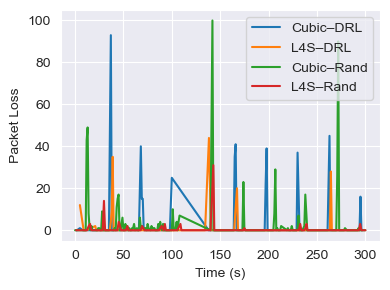

==== SUccess +++


In [112]:
for sno_aqm in range(len(latest_folders)):
    print("*=*"*50)
    print("AQM: ",latest_folders[sno_aqm]['tag'])
    print(latest_folders[sno_aqm])

    try:
        print("Try Success")
        
        paths = {
            "Cubic–DRL":extract_iperf3_data_df(latest_folders[sno_aqm]['DRL_allocation'][0]),
            "L4S–DRL":extract_udp_prague_to_dataframe(latest_folders[sno_aqm]['DRL_allocation'][2]),
            "Cubic–Rand":extract_iperf3_data_df(latest_folders[sno_aqm]['Random_allocation'][0]),
            "L4S–Rand":extract_udp_prague_to_dataframe(latest_folders[sno_aqm]['Random_allocation'][2]),
        }


        paths = {
            "Cubic–DRL":remove_outliers_iqr(extract_iperf3_data_df(latest_folders[sno_aqm]['DRL_allocation'][0])),
            "L4S–DRL":remove_outliers_iqr(extract_udp_prague_to_dataframe(latest_folders[sno_aqm]['DRL_allocation'][2])),
            "Cubic–Rand":remove_outliers_iqr(extract_iperf3_data_df(latest_folders[sno_aqm]['Random_allocation'][0])),
            "L4S–Rand":remove_outliers_iqr(extract_udp_prague_to_dataframe(latest_folders[sno_aqm]['Random_allocation'][2])),
        }

        plot_all_boxplot(paths)
        plot_all_cdf(paths)
        plot_all_timeseries(paths)


    except Exception as e:
        print(f"An error occurred while extracting and processing data: {e}")
    print("==== SUccess +++")

    


# Plotly

*=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=*
AQM:  fq_codel
{'tag': 'fq_codel', 'DRL_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_fq_codel\\iperf3_client_cubic_iperf3_d300_best_fq_codel.json', 'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_fq_codel\\iperf3_server_cubic_iperf3_d300_best_fq_codel.json', 'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_fq_codel\\udp_prague_receiver_iperf3_d300_best_fq_codel.json'], 'Random_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-15-05-15_baseline_fq_codel\\iperf3_client_cubic_iperf3_d300_basel

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




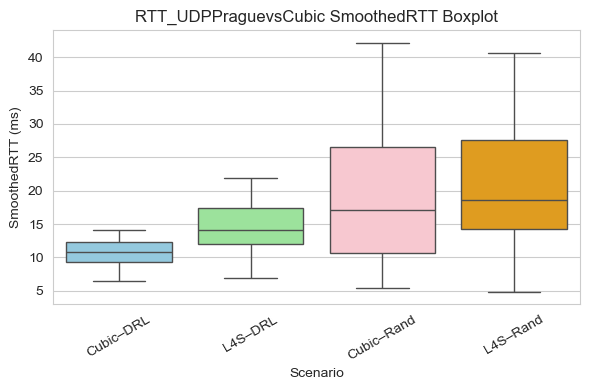

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




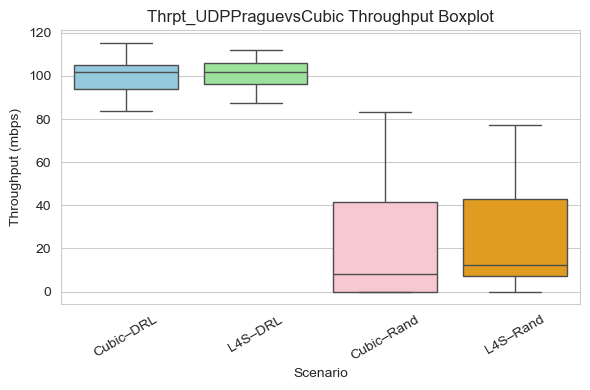

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




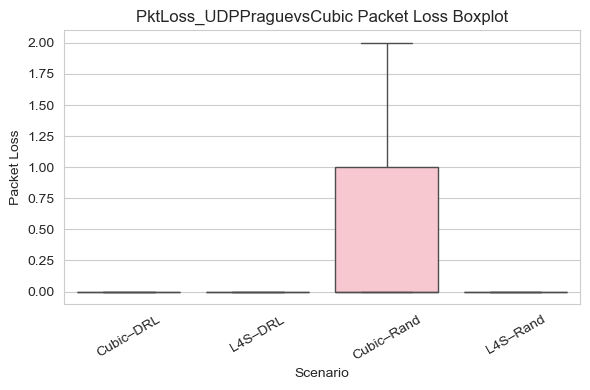

==== SUccess +++
*=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=*
AQM:  codel
{'tag': 'codel', 'DRL_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_codel\\iperf3_client_cubic_iperf3_d300_best_codel.json', 'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_codel\\iperf3_server_cubic_iperf3_d300_best_codel.json', 'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_codel\\udp_prague_receiver_iperf3_d300_best_codel.json'], 'Random_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-15-05-15_baseline_codel\\iperf3_client_cubic_iperf3_d300_baseline_codel.

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




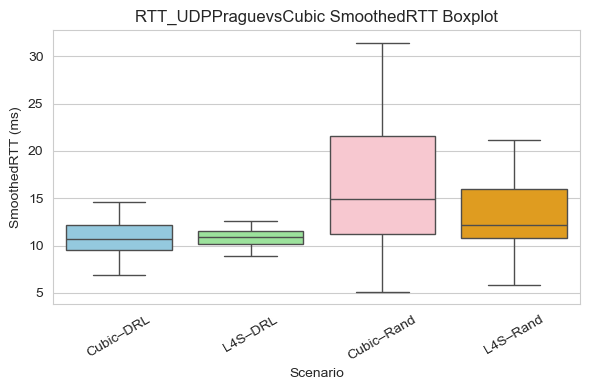

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




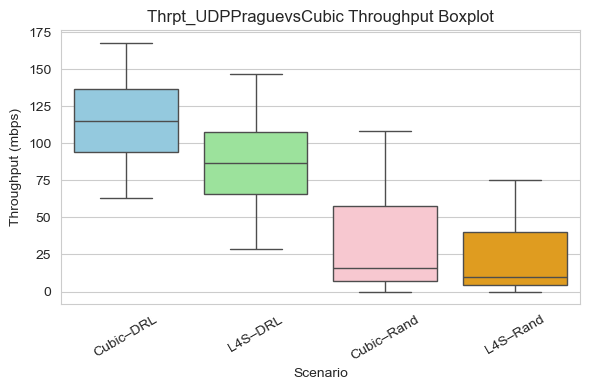

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




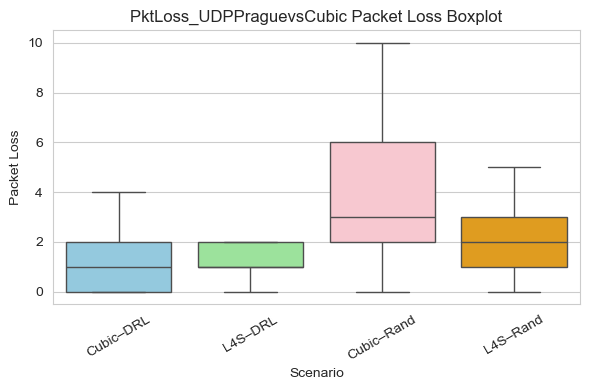

==== SUccess +++
*=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=*
AQM:  cake
{'tag': 'cake', 'DRL_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_cake\\iperf3_client_cubic_iperf3_d300_best_cake.json', 'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_cake\\iperf3_server_cubic_iperf3_d300_best_cake.json', 'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_cake\\udp_prague_receiver_iperf3_d300_best_cake.json'], 'Random_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-15-05-15_baseline_cake\\iperf3_client_cubic_iperf3_d300_baseline_cake.json', 'c:

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




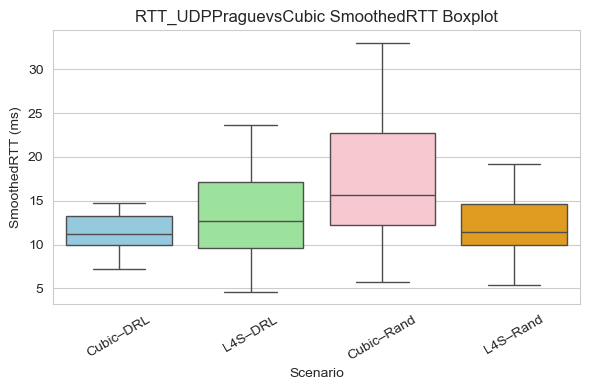

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




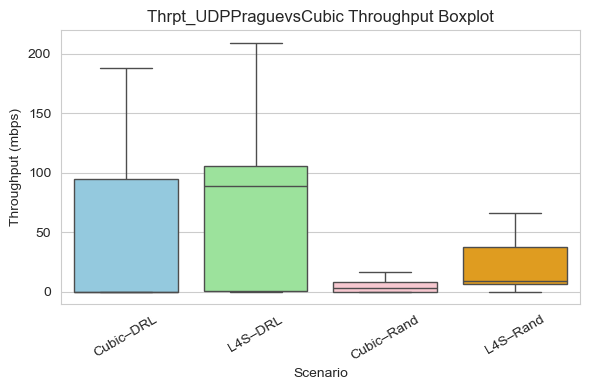

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




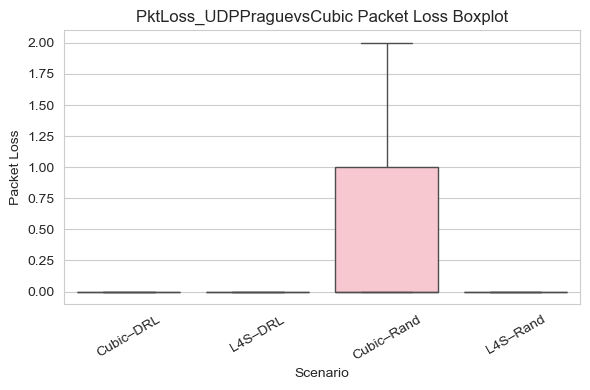

==== SUccess +++
*=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=*
AQM:  fq_pie
{'tag': 'fq_pie', 'DRL_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_fq_pie\\iperf3_client_cubic_iperf3_d300_best_fq_pie.json', 'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_fq_pie\\iperf3_server_cubic_iperf3_d300_best_fq_pie.json', 'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_fq_pie\\udp_prague_receiver_iperf3_d300_best_fq_pie.json'], 'Random_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-15-05-15_baseline_fq_pie\\iperf3_client_cubic_iperf3_d300_baseli

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




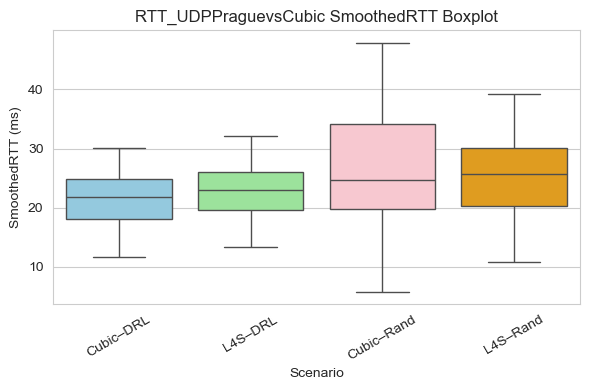

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




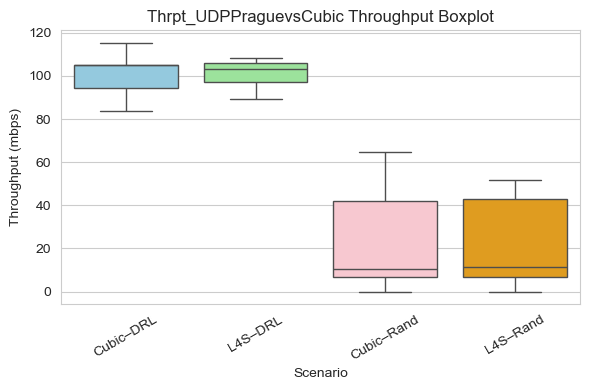

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




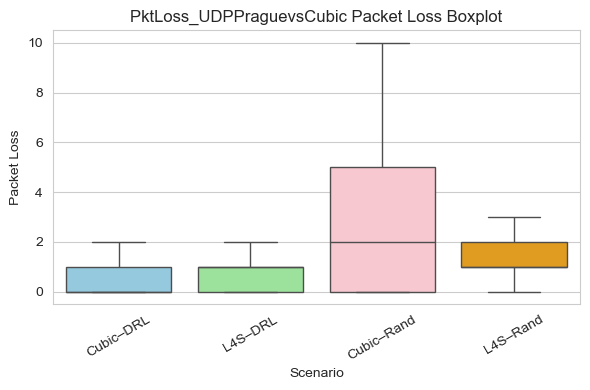

==== SUccess +++
*=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=*
AQM:  pfifo
{'tag': 'pfifo', 'DRL_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_pfifo\\iperf3_client_cubic_iperf3_d300_best_pfifo.json', 'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_pfifo\\iperf3_server_cubic_iperf3_d300_best_pfifo.json', 'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_pfifo\\udp_prague_receiver_iperf3_d300_best_pfifo.json'], 'Random_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-15-05-15_baseline_pfifo\\iperf3_client_cubic_iperf3_d300_baseline_pfifo.

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




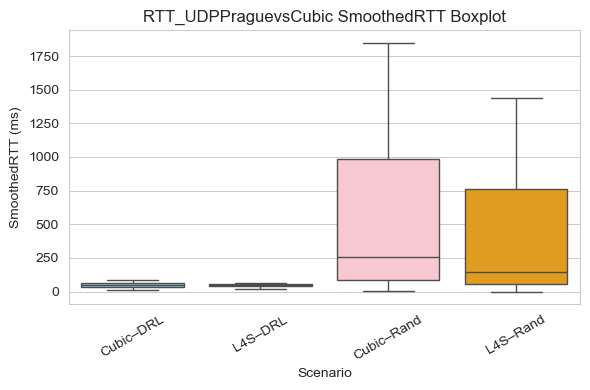

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




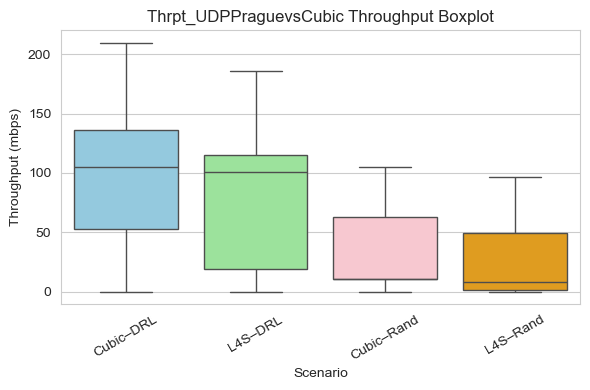

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




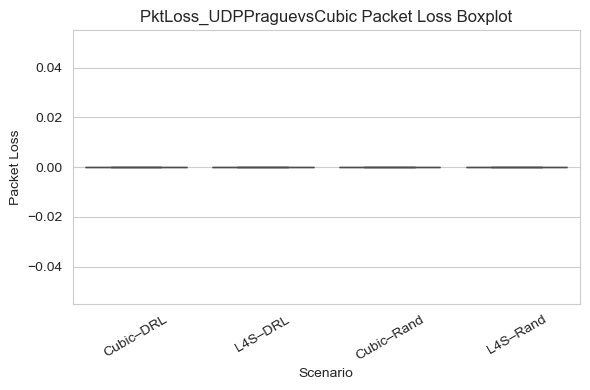

==== SUccess +++
*=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=*
AQM:  dualpi2
{'tag': 'dualpi2', 'DRL_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_dualpi2\\iperf3_client_cubic_iperf3_d300_best_dualpi2.json', 'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_dualpi2\\iperf3_server_cubic_iperf3_d300_best_dualpi2.json', 'c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-14-08-29_best_dualpi2\\udp_prague_receiver_iperf3_d300_best_dualpi2.json'], 'Random_allocation': ['c:\\Users\\deols\\OneDrive\\Documents\\Github\\Networking\\UbuntuSatLab\\Sat Testing Script\\data\\udp_net_2025-08-13-15-05-15_baseline_dualpi2\\iperf3_client_cubic_iperf3_d3

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




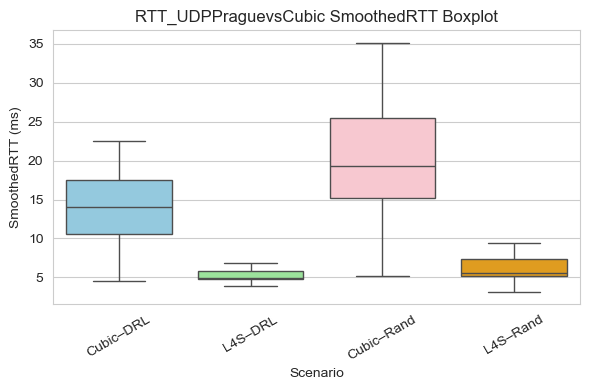

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




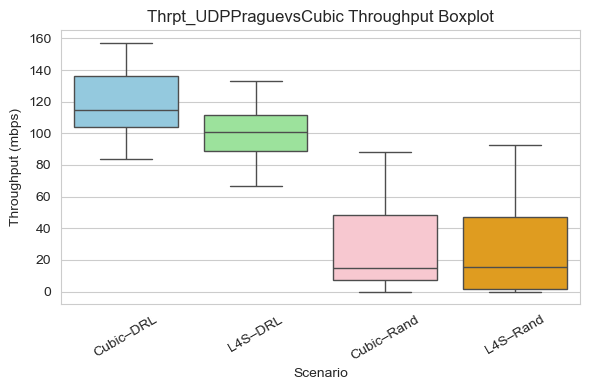

c:\Users\deols\OneDrive\Documents\Github\Networking\UbuntuSatLab\Sat Testing Script\viz_udp\utils\plotter.py:205: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




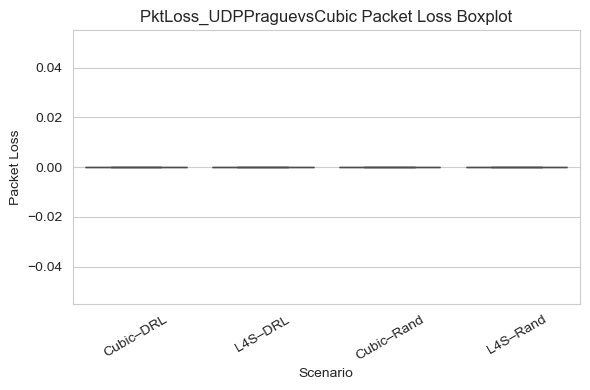

==== SUccess +++


In [ ]:
for sno_aqm in range(len(latest_folders)):
    print("*=*"*50)
    print("AQM: ",latest_folders[sno_aqm]['tag'])
    print(latest_folders[sno_aqm])

    try:
        print("Try Success")
        
        paths = {
            "Cubic–DRL":extract_iperf3_data_df(latest_folders[sno_aqm]['DRL_allocation'][0]),
            "L4S–DRL":extract_udp_prague_to_dataframe(latest_folders[sno_aqm]['DRL_allocation'][2]),
            "Cubic–Rand":extract_iperf3_data_df(latest_folders[sno_aqm]['Random_allocation'][0]),
            "L4S–Rand":extract_udp_prague_to_dataframe(latest_folders[sno_aqm]['Random_allocation'][2]),
        }


        # paths = {
        #     "Cubic–DRL":remove_outliers_iqr(extract_iperf3_data_df(latest_folders[sno_aqm]['DRL_allocation'][0])),
        #     "L4S–DRL":remove_outliers_iqr(extract_udp_prague_to_dataframe(latest_folders[sno_aqm]['DRL_allocation'][2])),
        #     "Cubic–Rand":remove_outliers_iqr(extract_iperf3_data_df(latest_folders[sno_aqm]['Random_allocation'][0])),
        #     "L4S–Rand":remove_outliers_iqr(extract_udp_prague_to_dataframe(latest_folders[sno_aqm]['Random_allocation'][2])),
        # }
        
        plot_all_boxplot(paths, tag)

        # scenario = "SmoothedRTT_UDPPraguevsCubic"
        # plot_plotly_graph(
        #     paths=paths,
        #     ycolumn="SmoothedRTT",
        #     title=f"{scenario} SmoothedRTT",
        #     xlabel="Time (s)",
        #     ylabel="SmoothedRTT (ms)",
        #     filename=f'{scenario}',
        #     graph_directory=graph_directory,
        # )

        # scenario = "Thrpt_UDPPraguevsCubic"
        # plot_plotly_graph(
        #     paths=paths,
        #     ycolumn="thrpt",
        #     title=f"{scenario} Throughput",
        #     xlabel="Time (s)",
        #     ylabel="Throughput (mbps)",
        #     filename=f'{scenario}',
        #     graph_directory=graph_directory,
        # )

        # scenario = "PktLoss_UDPPraguevsCubic"
        # plot_plotly_graph(
        #     paths=paths,
        #     ycolumn="Lost_Packets",
        #     title=f"{scenario} Packet Loss",
        #     xlabel="Time (s)",
        #     ylabel="Packet Loss",
        #     filename=f'{scenario}',
        #     graph_directory=graph_directory,
        # )



    except Exception as e:
        print(f"An error occurred while extracting and processing data: {e}")
    print("==== SUccess +++")

    


In [ ]:
scenario = "SmoothedRTT_UDPPraguevsCubic"
plot_plotly_graph(
    paths=paths,
    ycolumn="SmoothedRTT",
    title=f"{scenario} SmoothedRTT",
    xlabel="Time (s)",
    ylabel="SmoothedRTT (ms)",
    filename=f'{scenario}',
    graph_directory=graph_directory,
)

scenario = "Thrpt_UDPPraguevsCubic"
plot_plotly_graph(
    paths=paths,
    ycolumn="thrpt",
    title=f"{scenario} Throughput",
    xlabel="Time (s)",
    ylabel="Throughput (mbps)",
    filename=f'{scenario}',
    graph_directory=graph_directory,
)

scenario = "PktLoss_UDPPraguevsCubic"
plot_plotly_graph(
    paths=paths,
    ycolumn="Lost_Packets",
    title=f"{scenario} Packet Loss",
    xlabel="Time (s)",
    ylabel="Packet Loss",
    filename=f'{scenario}',
    graph_directory=graph_directory,
)


In [ ]:
# # Convert paths dict of DataFrames to dict of arrays for CDF plot
# def get_cdf_data(paths, ycolumn):
#     cdf_data = {}
#     for label, df in paths.items():
#         cdf_data[label] = df[ycolumn].dropna().values
#     return cdf_data


# scenario = "RTT_UDPPraguevsCubic"
# cdf_data = get_cdf_data(paths, "SmoothedRTT")
# plot_cdf_plotly(
#     data_dict=cdf_data,
#     xlabel="SmoothedRTT (ms)",
#     ylabel="CDF",
#     title=f"{scenario} SmoothedRTT CDF",
#     filename=f"{scenario}_SmoothedRTT_CDF",
#     folder=graph_directory,
# )

# scenario = "Thrpt_UDPPraguevsCubic"
# cdf_data = get_cdf_data(paths, "thrpt")
# plot_cdf_plotly(
#     data_dict=cdf_data,
#     xlabel="Throughput (mbps)",
#     ylabel="CDF",
#     title=f"{scenario} Throughput CDF",
#     filename=f"{scenario}_Thrpt_CDF",
#     folder=graph_directory,
# )

# scenario = "PktLoss_UDPPraguevsCubic"
# cdf_data = get_cdf_data(paths, "Lost_Packets")
# plot_cdf_plotly(
#     data_dict=cdf_data,
#     xlabel="Packet Loss",
#     ylabel="CDF",
#     title=f"{scenario} Packet Loss CDF",
#     filename=f"{scenario}_PktLoss_CDF",
#     folder=graph_directory,
# )


In [ ]:
# for folder_name, files in files_dict.items():
#     print(f"Folder: {folder_name}")
#     # for file in files:
#     #     print(f"  - {file}")

#     file_udp = files[2]
#     file_cubic = files[0]

#     # print("file_cubic",file_cubic)
#     # print("file_udp",file_udp)
#     tfcubic = extract_iperf3_data_df(file_cubic)
#     utf = extract_udp_prague_to_dataframe(file_udp)





#     # Define paths
#     paths = {
#         "Cubic": tfcubic,
#         "L4S": utf,
#         # "Bandwidth": baseline_throuhgput_df
#     }

    


#     scenario = str("RTT_UDPPraguevsCubic")
#     plot_matplotlib_graph(paths=paths,
#                     ycolumn="SmoothedRTT",
#                     title=f"{scenario} SmoothedRTT",
#                     xlabel="Time (s)",
#                     ylabel="SmoothedRTT (ms)",
#                     filename=f'{scenario}',
#                     graph_directory=graph_directory,
#     )

#     scenario = str("Thrpt_UDPPraguevsCubic")
#     plot_matplotlib_graph(paths=paths,
#                     ycolumn="thrpt",
#                     title=f"{scenario} Throuhghput",
#                     xlabel="Time (s)",
#                     ylabel="Throuhghput (mbps)",
#                     filename=f'{scenario}',
#                     graph_directory=graph_directory,
#     )


#     scenario = str("PktLoss_UDPPraguevsCubic")
#     plot_matplotlib_graph(paths=paths,
#                     ycolumn="Lost_Packets",
#                     title=f"{scenario} Packet Loss",
#                     xlabel="Time (s)",
#                     ylabel="Packet Loss",
#                     filename=f'{scenario}',
#                     graph_directory=graph_directory,
#     )

